# Activation maximization

We are using this: https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb


In [4]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 6)

from keras.datasets import mnist # subroutines for fetching the CIFAR-10 dataset
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np



Let's fetch fashion-mnist data

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() 


Let's set some important variables

- num_train, num_test: number of training/test instances
- height, width, depth: Shape of images
- num_classes: number of output classes (there should be 10)

In [6]:
X_train.shape

(60000, 28, 28)

In [12]:

num_train, height, width = X_train.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

print("Shape of images {}: ".format((height, width)))

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')


ValueError: too many values to unpack (expected 3)

Let's show one of these images...

(28, 28)


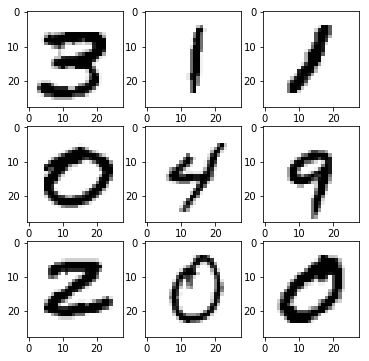

In [8]:
import matplotlib.pyplot as plt
print(X_train[12].shape)

base = 110

for i in range(1, 10):
    plt.subplot(3,3,i)
    plt.imshow(X_train[base+i], cmap=plt.cm.gray_r)

Add dummy dimension

In [9]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train.shape

(60000, 28, 28, 1)

In [10]:
X_train /= np.max(X_train) # Normalise data to [0, 1] range
X_test /= np.max(X_test) # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

Let's make our first model. Just two convolutions, one maxpool, a flatten, and a softmax layer.

# Convolutional model

In [31]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,))

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

input_shape = (height, width, 1)
num_classes = 10

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=3,
          verbose=1)



Epoch 1/3
60000/60000 [==============================] - 234s 4ms/step - loss: 0.1857 - acc: 0.9439
Epoch 2/3
60000/60000 [==============================] - 218s 4ms/step - loss: 0.0786 - acc: 0.9763
Epoch 3/3
60000/60000 [==============================] - 226s 4ms/step - loss: 0.0619 - acc: 0.9811


ValueError: Error when checking target: expected dense_16 to have shape (None, 10) but got array with shape (10000, 1)

In [33]:
model.evaluate(X_test, Y_test, verbose=1)

10000/10000 [==============================] - 10s 1ms/step


[0.029911779709485928, 0.99070000000000003]


## Output of first convolutional layer

What does the output of the convolutional layer look like?

(28, 28, 1)

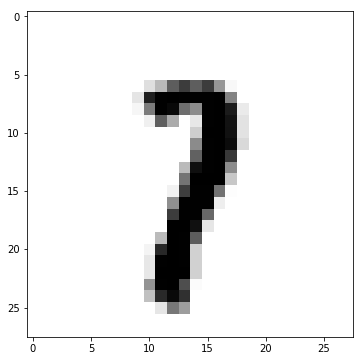

In [34]:
from keras import backend as K

def show_image(img):
    plt.imshow(np.squeeze(img), cmap=plt.cm.gray_r)

X = X_test[111]    
show_image(X)


X.shape

In [35]:
from keras import Model

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
intermediate_output = np.squeeze(intermediate_layer_model.predict(X[np.newaxis, ...]))

How does the first layer process our image?

(3, 3, 32)


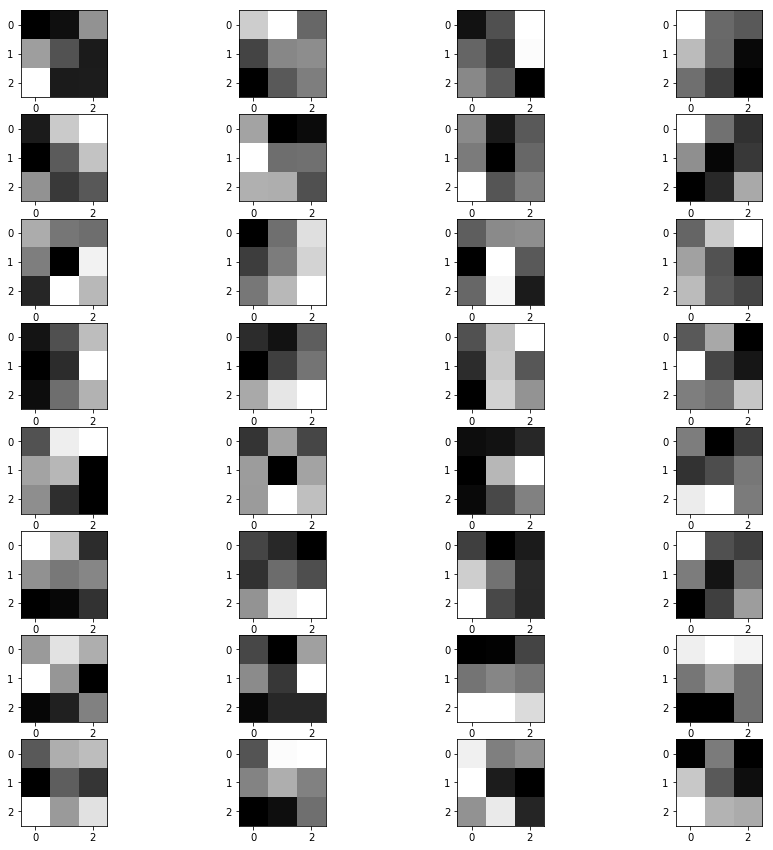

In [39]:
conv_layer = model.layers[0]

weights = np.squeeze(conv_layer.get_weights()[0])


print(weights.shape)
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(weights[:,:, i], cmap=plt.cm.gray_r)


## Maximizing the output of the softmax Layer

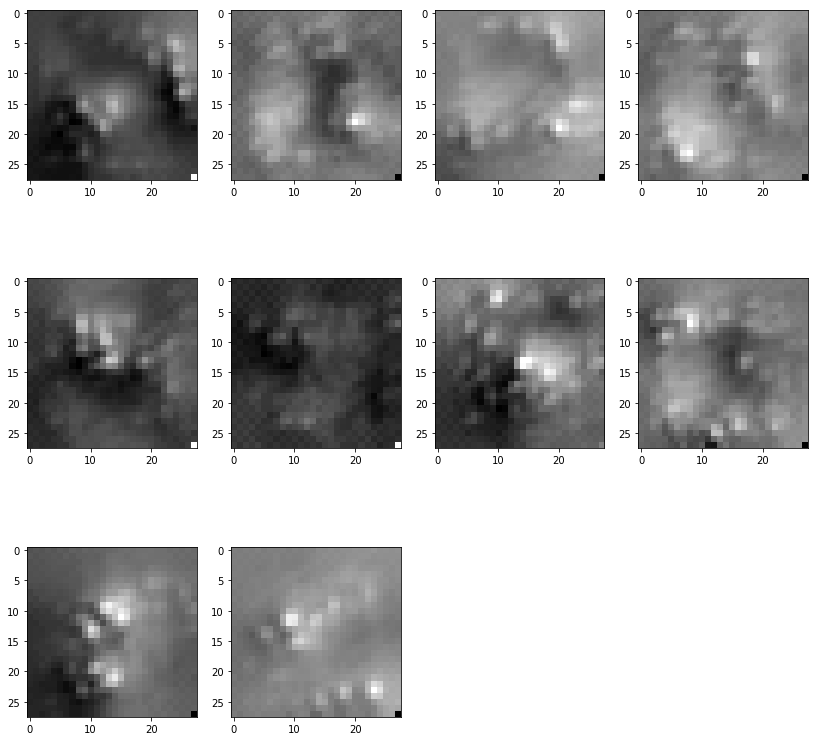

In [64]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

plt.rcParams['figure.figsize'] = (14, 14)

# Swap softmax with linear
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.

for filter_idx in range(10):
    img = visualize_activation(model, -1, filter_indices=filter_idx)
    plt.subplot(3,4,filter_idx+1)
    plt.imshow(img[..., 0], cmap=plt.cm.gray_r)




They are not as clear as we would expect! First, we should set a boundary to the input

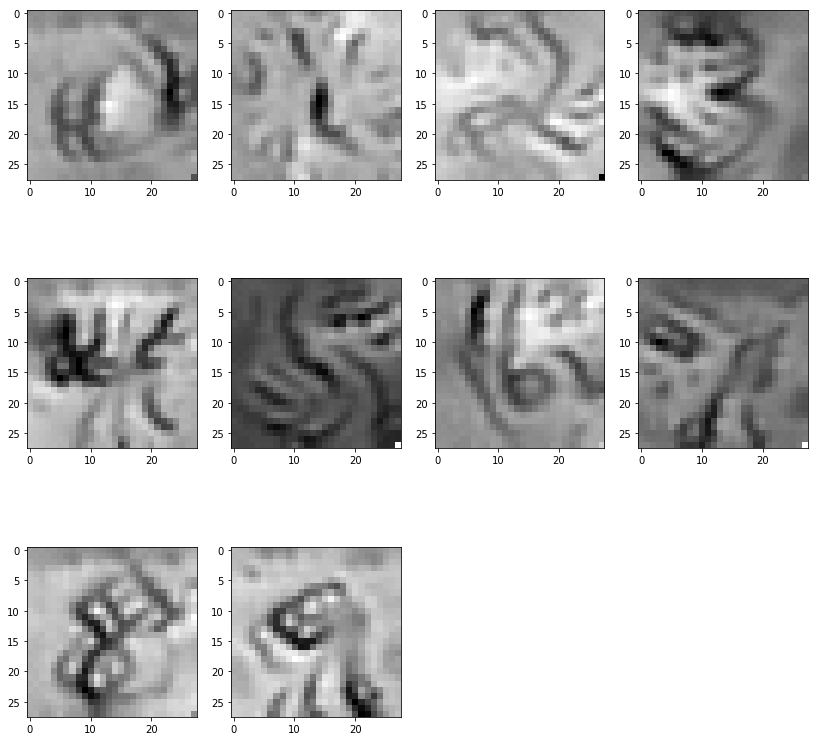

In [65]:

for filter_idx in range(10):
    img = visualize_activation(model, -1, filter_indices=filter_idx, input_range=(0., 1.))
    plt.subplot(3,4,filter_idx+1)
    plt.imshow(img[..., 0], cmap=plt.cm.gray_r)